In [1]:
import sys
from pathlib import Path
import shutil
import pickle
from typing import List, Dict, Union

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist

sys.path.append('..')

from src.engineer.nigeria import NigeriaDataInstance, NigeriaEngineerNew
from src.utils.samplers import BoundedUniformSampler

distance_between_two_points_km = BoundedUniformSampler.distance_between_two_points_km

%reload_ext autoreload
%autoreload 2

## Get data

In [2]:
data_path = Path('../data/features/nigeria')

In [7]:
subsets = ['training', 'validation', 'testing']
rows = []
for subset in subsets:
    pickle_files = [file for file in (data_path / subset).glob('*.pkl')]
    for file in pickle_files:
        identifier = file.name.split('_')[0]
        date = '_'.join(pickle_files[0].name.split('_')[1:]).split('.')[0]
        with file.open("rb") as f:
            target_datainstance = pickle.load(f)
        assert isinstance(target_datainstance, NigeriaDataInstance), 'Pickle file is not an instance of geowiki data'
        label = target_datainstance.is_crop

        rows.append((
            identifier,
            date,
            target_datainstance.instance_lat,
            target_datainstance.instance_lon,
            label,
            file.name,
            subset
            ))

In [8]:
df = pd.DataFrame(rows, columns=['identifier', 'date', 'lat', 'lon', 'label', 'filename', 'set'])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat), crs='epsg:4326')
gdf

,identifier,date,lat,lon,label,filename,set,geometry
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379)
1,22,2019-04-03_2020-03-28,12.720998,11.665657,0,22_2019-04-03_2020-03-28.pkl,training,POINT (11.66566 12.72100)
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528)
3,372,2019-04-03_2020-03-28,5.029802,6.423448,0,372_2019-04-03_2020-03-28.pkl,training,POINT (6.42345 5.02980)
4,345,2019-04-03_2020-03-28,10.169154,3.810788,0,345_2019-04-03_2020-03-28.pkl,training,POINT (3.81079 10.16915)
...,...,...,...,...,...,...,...,...
1822,1821,2019-04-03_2020-03-28,12.432728,12.860416,1,1821_2019-04-03_2020-03-28.pkl,testing,POINT (12.86042 12.43273)
1823,1495,2019-04-03_2020-03-28,8.249813,6.666982,1,1495_2019-04-03_2020-03-28.pkl,testing,POINT (6.66698 8.24981)
1824,1390,2019-04-03_2020-03-28,4.725363,7.672107,0,1390_2019-04-03_2020-03-28.pkl,testing,POINT (7.67211 4.72536)
1825,1361,2019-04-03_2020-03-28,6.654585,9.413760,0,1361_2019-04-03_2020-03-28.pkl,testing,POINT (9.41376 6.65458)


## Label distribution

In [9]:
label_dist = gdf.groupby(['set'])['label'].agg(['count', 'sum'])
label_dist['ratio'] = label_dist['sum'] / label_dist['count']
label_dist.loc['total'] = [len(gdf), gdf['label'].sum(), gdf['label'].sum()/len(gdf)]
label_dist.rename(columns={'sum': 'cropland_count'}, inplace=True)
label_dist

,count,cropland_count,ratio
set,,,
testing,348.0,129.0,0.370690
training,1083.0,442.0,0.408126
validation,396.0,174.0,0.439394
total,1827.0,745.0,0.407772


## Visualize spatial distribution and save

<AxesSubplot:>

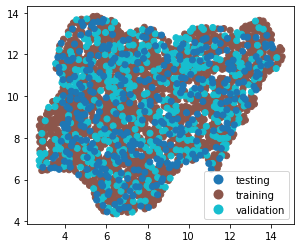

In [10]:
gdf.plot(column='set', legend=True)

## Find minimum distance between points

In [11]:
df_lonlats = gdf[['lon', 'lat']].copy()
dm = squareform(pdist(df_lonlats, distance_between_two_points_km)) # same as cdist(df_lonlats, df_lonlats, distance_between_two_points_km)
distances_df = pd.DataFrame(dm, index=df_lonlats.index, columns=df_lonlats.index)
np.fill_diagonal(distances_df.values, np.inf)  # Makes it easier to find minimums

In [12]:
df_lonlats['closest_point_index'] = distances_df.loc[df_lonlats.index, df_lonlats.index].idxmin()
df_lonlats['closest_point_distance_km'] = distances_df.loc[df_lonlats.index, df_lonlats.index].min()
df_lonlats

,lon,lat,closest_point_index,closest_point_distance_km
0,7.027655,6.993789,356,15.711070
1,11.665657,12.720998,911,19.250201
2,4.593760,8.605277,919,16.767350
3,6.423448,5.029802,349,20.619641
4,3.810788,10.169154,1499,19.502016
...,...,...,...,...
1822,12.860416,12.432728,651,17.327693
1823,6.666982,8.249813,1034,23.037610
1824,7.672107,4.725363,617,15.482028
1825,9.413760,6.654585,416,17.216535


## Sample points from existing set with buffer

In [13]:
# class BufferedResampler?
def is_within_buffer_from_each_point(new_lon: float, new_lat: float, points_df: pd.DataFrame, buffer_km: float) -> bool:
    '''
    Returns True if new point is within the buffer distance (in km) from any point in points.
    ''' 
    for index, point in points_df.iterrows():
        lon, lat = point['lon'], point['lat']
        if new_lon == lon and new_lat == lat:
            return True
        distance = distance_between_two_points_km((new_lon, new_lat), (lon, lat))
        if distance < buffer_km:
            #print('too close!', distance)
            return True
    return False

def sample_n_points(df, n, buffer_km):    
    i = 0
    points = pd.DataFrame()
    while i < n:
        point = df.sample(1)
        lon = float(point['lon'].values)
        lat = float(point['lat'].values)
        too_close = is_within_buffer_from_each_point(lon, lat, points, buffer_km)
        if not too_close:
            #points.append((lon, lat))
            points = pd.concat([points, point])
            i += 1
    return points

def resample_splits_with_buffer(gdf, val_set_size, test_set_size, buffer):
    
    n_test = int(test_set_size * len(gdf))
    n_val = int(test_set_size * len(gdf))
    
    # Get test set
    test_set = sample_n_points(gdf, n_test, buffer)
    test_set['new_set'] = 'testing'
    
    # Get validation set
    train_val_set = gdf.iloc[gdf.index.difference(test_set.index)]
    val_set = sample_n_points(train_val_set, n_val, buffer)
    val_set['new_set'] = 'validation'

    # Get training set
    train_set = gdf.iloc[train_val_set.index.difference(val_set.index)]
    train_set['new_set'] = 'training'

    # Merge sets
    new_gdf = pd.concat([train_set, val_set, test_set])   
    assert len(gdf) == len(new_gdf), 'Number of samples is not preserved'

    return new_gdf

def move_files(new_gdf: gpd.GeoDataFrame, parent_path: Path, keep_original: bool) -> None:
    keep_original = True
    keep_original = False if (parent_path / 'original_split').exists() else keep_original # only do it the first time
    if keep_original:
        # Copy original directory into a new subfolder 
        shutil.copytree(parent_path, parent_path / 'original_split')

    for index, row in new_gdf.iterrows():
        source_path = parent_path / row['set'] / row['filename']
        dest_path = parent_path / row['new_set'] / row['filename']
        if source_path == dest_path:
            continue
        shutil.move(source_path, dest_path)

In [4]:
class BufferedResampler:

    subsets = ['training', 'validation', 'testing']

    def __init__(self, data_path, val_set_size, test_set_size, buffer, engineer):
        self.data_path = data_path
        self.val_set_size = val_set_size
        self.test_set_size = test_set_size
        self.buffer = buffer
        self.engineer = engineer

    def read_labels(self) -> gpd.GeoDataFrame:
        rows = []
        for subset in self.subsets:
            pickle_files = [file for file in (self.data_path / subset).glob('*.pkl')]
            for file in pickle_files:
                identifier = file.name.split('_')[0]
                date = '_'.join(pickle_files[0].name.split('_')[1:]).split('.')[0]
                with file.open("rb") as f:
                    target_datainstance = pickle.load(f)
                assert isinstance(target_datainstance, NigeriaDataInstance), 'Pickle file is not an instance of geowiki data'
                label = target_datainstance.is_crop

                rows.append((identifier,
                    date,
                    target_datainstance.instance_lat,
                    target_datainstance.instance_lon,
                    label,
                    file.name,
                    subset
                    ))

        df = pd.DataFrame(rows, columns=['identifier', 'date', 'lat', 'lon', 'label', 'filename', 'set'])
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat), crs='epsg:4326')
        return gdf

    @staticmethod
    def get_label_distribution(df: Union[pd.DataFrame, gpd.GeoDataFrame], column_to_groupby: str = 'set') -> pd.DataFrame:
        label_dist = df.groupby([column_to_groupby])['label'].agg(['count', 'sum'])
        label_dist['ratio'] = label_dist['sum'] / label_dist['count']
        label_dist.loc['total'] = [len(df), df['label'].sum(), df['label'].sum()/len(df)]
        label_dist.rename(columns={'sum': 'cropland_count'}, inplace=True)
        print(label_dist)
        return label_dist
    
    @staticmethod
    def is_within_buffer_from_each_point(new_lon: float, new_lat: float, points_df: pd.DataFrame, buffer_km: float) -> bool:
        '''
        Returns True if new point is within the buffer distance (in km) from any point in points.
        ''' 
        for index, point in points_df.iterrows():
            lon, lat = point['lon'], point['lat']
            if new_lon == lon and new_lat == lat:
                return True
            distance = distance_between_two_points_km((new_lon, new_lat), (lon, lat))
            if distance < buffer_km:
                #print('too close!', distance)
                return True
        return False

    def sample_n_points_with_buffer(self, df: Union[pd.DataFrame, gpd.GeoDataFrame], n: int, buffer_km: float) -> pd.DataFrame:    
        i = 0
        points = pd.DataFrame()
        while i < n:
            point = df.sample(1)
            lon = float(point['lon'].values)
            lat = float(point['lat'].values)
            too_close = self.is_within_buffer_from_each_point(lon, lat, points, buffer_km)
            if not too_close:
                points = pd.concat([points, point])
                i += 1
        return points

    def resample_splits_with_buffer(self, gdf):
        
        n_test = int(self.test_set_size * len(gdf))
        n_val = int(self.test_set_size * len(gdf))
        
        print("Resampling...")
        # Get test set
        test_set = self.sample_n_points_with_buffer(gdf, n_test, self.buffer)
        test_set['new_set'] = 'testing'
        
        # Get validation set
        train_val_set = gdf.iloc[gdf.index.difference(test_set.index)]
        val_set = self.sample_n_points_with_buffer(train_val_set, n_val, self.buffer)
        val_set['new_set'] = 'validation'

        # Get training set
        train_set = gdf.iloc[train_val_set.index.difference(val_set.index)]
        train_set['new_set'] = 'training'

        # Merge sets
        new_gdf = pd.concat([train_set, val_set, test_set])   
        assert len(gdf) == len(new_gdf), 'Number of samples is not preserved'

        return new_gdf

    def move_files(self, new_gdf: gpd.GeoDataFrame, backup_original: bool=True) -> None:
        backup_path = self.data_path / 'original_split'
        backup_original = False if backup_path.exists() else backup_original # only do it the first time
        if backup_original:
            # Copy original directory into a new subfolder 
            shutil.copytree(self.data_path, backup_path)

        for index, row in new_gdf.iterrows():
            source_path = self.data_path / row['set'] / row['filename']
            dest_path = self.data_path / row['new_set'] / row['filename']
            if source_path == dest_path:
                continue
            shutil.move(source_path, dest_path)

    def recalculate_normalizing_dict(self, dict_file_name: str = "normalizing_dict.pkl") -> Dict:
        
        dict_path = self.data_path / dict_file_name
        
        if dict_path.exists():
            with dict_path.open("rb") as f:
                normalizing_dict1 = pickle.load(f)
        print('original dict:', normalizing_dict1)

        for subset in ['training', 'validation']:
            pickle_files = [file for file in (self.data_path / subset).glob('*.pkl')]
            for file_path in pickle_files:
                with file_path.open("rb") as f:   
                    target_datainstance = pickle.load(f)
                self.engineer.update_normalizing_values(target_datainstance.labelled_array)  

        normalizing_dict = self.engineer.calculate_normalizing_dict()
        print('new dict:', normalizing_dict)

        with dict_path.open("wb") as f:
            print("Saved new normalizing dictionary:", dict_path)
            pickle.dump(normalizing_dict, f)

        # # Checks
        # print(all(normalizing_dict1['mean'].round(12) == normalizing_dict['mean'].round(12)))
        # print(all(normalizing_dict1['std'].round(12) == normalizing_dict['std'].round(12)))

        return normalizing_dict


    def resample(self) -> None:
        gdf = self.read_labels() # new to read labels again because of new paths
        self.get_label_distribution(gdf)
        new_gdf = self.resample_splits_with_buffer(gdf)
        self.get_label_distribution(new_gdf, column_to_groupby='new_set')
        self.move_files(new_gdf)
        self.recalculate_normalizing_dict()
        new_gdf.to_file(self.data_path / 'nigeria_stratified_labelled_v1_splits_resampled.shp')

In [10]:
data_path = Path('../data_split_test/nigeria')

In [154]:
engineer = NigeriaEngineerNew(Path('../data'))
resampler = BufferedResampler(data_path, test_set_size=0.25, val_set_size=0.25, buffer=30, engineer=engineer)
resampler.resample()

             count  cropland_count     ratio
set                                         
testing      456.0           199.0  0.436404
training     915.0           366.0  0.400000
validation   456.0           180.0  0.394737
total       1827.0           745.0  0.407772
Resampling...


/home/gajo/miniconda3/envs/togo-paper/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


             count  cropland_count     ratio
new_set                                     
testing      456.0           207.0  0.453947
training     915.0           363.0  0.396721
validation   456.0           175.0  0.383772
total       1827.0           745.0  0.407772
original dict: {'mean': array([0.1732286 , 0.15287333, 0.15192979, 0.15677769, 0.17883293,
       0.25420106, 0.29650125, 0.28048476, 0.32660169, 0.07026846,
       0.00797023, 0.28642317, 0.19018893, 0.31185447]), 'std': array([0.07568598, 0.07750014, 0.07671434, 0.09509806, 0.08802793,
       0.08158046, 0.08887607, 0.08293812, 0.0916664 , 0.05654532,
       0.02084311, 0.11199392, 0.1036192 , 0.1956636 ])}
new dict: {'mean': array([0.17387161, 0.15356882, 0.15248219, 0.15716256, 0.17900921,
       0.25387664, 0.29599182, 0.27983573, 0.32585052, 0.07015501,
       0.00811089, 0.28505149, 0.18935582, 0.31008796]), 'std': array([0.07768806, 0.07937646, 0.07849483, 0.0966799 , 0.08961249,
       0.08304495, 0.09003331, 0.

In [15]:
data_path = Path('../data/features/nigeria') # after resampling
engineer = NigeriaEngineerNew(Path('../data'))
resampler = BufferedResampler(data_path, test_set_size=0.25, val_set_size=0.25, buffer=30, engineer=engineer)
gdf = resampler.read_labels()
resampler.get_label_distribution(gdf)

             count  cropland_count     ratio
set                                         
testing      456.0           183.0  0.401316
training     915.0           381.0  0.416393
validation   456.0           181.0  0.396930
total       1827.0           745.0  0.407772


,count,cropland_count,ratio
set,,,
testing,456.0,183.0,0.401316
training,915.0,381.0,0.416393
validation,456.0,181.0,0.396930
total,1827.0,745.0,0.407772


# Experimentation only
Not in chronological order so will probably thorugh errors!

In [5]:
gdf = resampler.read_labels()
resampler.get_label_distribution(gdf)

,count,cropland_count,ratio
set,,,
testing,348.0,129.0,0.370690
training,1083.0,442.0,0.408126
validation,396.0,174.0,0.439394
total,1827.0,745.0,0.407772


In [98]:
new_gdf = resampler.resample_splits_with_buffer(gdf)
resampler.get_label_distribution(new_gdf, column_to_groupby='new_set')

/home/gajo/miniconda3/envs/togo-paper/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,count,cropland_count,ratio
new_set,,,
testing,456.0,197.0,0.432018
training,915.0,371.0,0.405464
validation,456.0,177.0,0.388158
total,1827.0,745.0,0.407772


In [ ]:
resampler.move_files()

In [117]:
engineer = NigeriaEngineerNew(Path('../data'))
resampler.recalculate_normalizing_dict(engineer)

original dict: {'mean': array([0.17359276, 0.1533098 , 0.15235488, 0.15748606, 0.1793485 ,
       0.25449725, 0.29681016, 0.28073279, 0.3269152 , 0.07033559,
       0.00811504, 0.28734444, 0.19111746, 0.30969277]), 'std': array([0.07539527, 0.07694851, 0.07622905, 0.09473133, 0.08780151,
       0.08150286, 0.08885432, 0.08280394, 0.09171689, 0.05671821,
       0.02133957, 0.11223117, 0.10345545, 0.1955927 ])}
new dict: {'mean': array([0.17359276, 0.1533098 , 0.15235488, 0.15748606, 0.1793485 ,
       0.25449725, 0.29681016, 0.28073279, 0.3269152 , 0.07033559,
       0.00811504, 0.28734444, 0.19111746, 0.30969277]), 'std': array([0.07539527, 0.07694851, 0.07622905, 0.09473133, 0.08780151,
       0.08150286, 0.08885432, 0.08280394, 0.09171689, 0.05671821,
       0.02133957, 0.11223117, 0.10345545, 0.1955927 ])}
Saved new normalizing dictionary: ../data_split_test/nigeria/normalizing_dict.pkl
True
True


In [14]:
test_set_size = 0.25
val_set_size = 0.25
buffer = 30

new_gdf = resample_splits_with_buffer(gdf, val_set_size, test_set_size, buffer)

/home/gajo/miniconda3/envs/togo-paper/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [19]:
new_gdf

,identifier,date,lat,lon,label,filename,set,geometry,new_set
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379),training
1,22,2019-04-03_2020-03-28,12.720998,11.665657,0,22_2019-04-03_2020-03-28.pkl,training,POINT (11.66566 12.72100),training
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528),training
5,637,2019-04-03_2020-03-28,11.347294,13.610150,0,637_2019-04-03_2020-03-28.pkl,training,POINT (13.61015 11.34729),training
6,1803,2019-04-03_2020-03-28,12.330321,11.564147,1,1803_2019-04-03_2020-03-28.pkl,training,POINT (11.56415 12.33032),training
...,...,...,...,...,...,...,...,...,...
1271,549,2019-04-03_2020-03-28,6.324095,6.155032,0,549_2019-04-03_2020-03-28.pkl,validation,POINT (6.15503 6.32409),testing
564,84,2019-04-03_2020-03-28,8.247298,11.849812,0,84_2019-04-03_2020-03-28.pkl,training,POINT (11.84981 8.24730),testing
1597,452,2019-04-03_2020-03-28,11.720185,4.108849,1,452_2019-04-03_2020-03-28.pkl,testing,POINT (4.10885 11.72018),testing
1133,819,2019-04-03_2020-03-28,7.418333,6.159703,0,819_2019-04-03_2020-03-28.pkl,validation,POINT (6.15970 7.41833),testing


<AxesSubplot:>

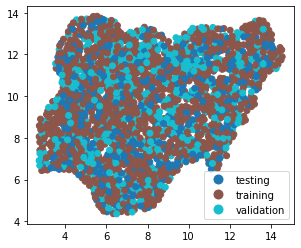

In [17]:
new_gdf.plot(column='set', legend=True)

<AxesSubplot:>

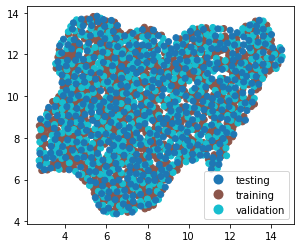

In [18]:
new_gdf.plot(column='new_set', legend=True)

In [20]:
label_dist = new_gdf.groupby(['new_set'])['label'].agg(['count', 'sum'])
label_dist['ratio'] = label_dist['sum'] / label_dist['count']
label_dist.loc['total'] = [len(new_gdf), new_gdf['label'].sum(), new_gdf['label'].sum()/len(new_gdf)]
label_dist.rename(columns={'sum': 'cropland_count'}, inplace=True)
label_dist

,count,cropland_count,ratio
new_set,,,
testing,456.0,178.0,0.390351
training,915.0,369.0,0.403279
validation,456.0,198.0,0.434211
total,1827.0,745.0,0.407772


In [108]:
test_set_size = 0.25
val_set_size = 0.25
buffer = 30

n_test = int(test_set_size * len(gdf))
n_val = int(test_set_size * len(gdf))
n_train = len(gdf) - n_val - n_test

In [109]:
test_set = sample_n_points(gdf, n_test, buffer)
test_set['set'] = 'testing'
test_set

too close! 24.64645316004673
too close! 24.198514394207773
too close! 29.49057289745187
too close! 15.50380268537089
too close! 21.455625637848538
too close! 29.87124819773322
too close! 21.205695216511565
too close! 26.74383260887917
too close! 24.171241893736294
too close! 26.99451287879321
too close! 28.194804852326403
too close! 18.66051800539894
too close! 20.09917028255607
too close! 23.60537693022341
too close! 18.59357370134069
too close! 28.95676480183917
too close! 29.603496578982423
too close! 22.025422695816882
too close! 24.884398519898678
too close! 17.042649863490375
too close! 20.9184366154739
too close! 25.05168927143398
too close! 15.117529444830662
too close! 17.774500570078377
too close! 26.093233625805954
too close! 24.815307581631465
too close! 16.705499219067924
too close! 19.434681131613296
too close! 24.274078733904467
too close! 26.36278544091395
too close! 28.741432347780332
too close! 20.755481369336437
too close! 21.828493449774893
too close! 16.29463131682

,identifier,date,lat,lon,label,filename,set,geometry
1426,533,2019-04-03_2020-03-28,10.542134,12.914675,1,533_2019-04-03_2020-03-28.pkl,testing,POINT (12.91467 10.54213)
1104,52,2019-04-03_2020-03-28,7.967742,8.557037,1,52_2019-04-03_2020-03-28.pkl,testing,POINT (8.55704 7.96774)
164,214,2019-04-03_2020-03-28,9.048056,7.192406,0,214_2019-04-03_2020-03-28.pkl,testing,POINT (7.19241 9.04806)
24,543,2019-04-03_2020-03-28,9.722152,12.910542,0,543_2019-04-03_2020-03-28.pkl,testing,POINT (12.91054 9.72215)
917,875,2019-04-03_2020-03-28,12.886557,6.621437,1,875_2019-04-03_2020-03-28.pkl,testing,POINT (6.62144 12.88656)
...,...,...,...,...,...,...,...,...
984,183,2019-04-03_2020-03-28,4.984168,7.111109,0,183_2019-04-03_2020-03-28.pkl,testing,POINT (7.11111 4.98417)
1757,1192,2019-04-03_2020-03-28,13.223426,4.353820,0,1192_2019-04-03_2020-03-28.pkl,testing,POINT (4.35382 13.22343)
1001,814,2019-04-03_2020-03-28,5.214316,7.544546,0,814_2019-04-03_2020-03-28.pkl,testing,POINT (7.54455 5.21432)
251,435,2019-04-03_2020-03-28,13.091463,13.307508,0,435_2019-04-03_2020-03-28.pkl,testing,POINT (13.30751 13.09146)


In [110]:
test_set['label'].sum()/len(test_set)

0.38377192982456143

<AxesSubplot:>

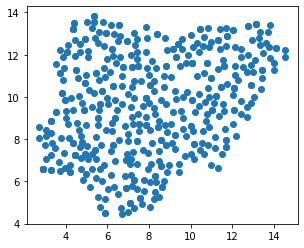

In [111]:
test_set.plot()

### Get other split and label distribution

In [51]:
train_val_set = gdf.iloc[gdf.index.difference(test_set.index)]
train_val_set

,identifier,date,lat,lon,label,filename,set,geometry
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379)
1,22,2019-04-03_2020-03-28,12.720998,11.665657,0,22_2019-04-03_2020-03-28.pkl,training,POINT (11.66566 12.72100)
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528)
3,372,2019-04-03_2020-03-28,5.029802,6.423448,0,372_2019-04-03_2020-03-28.pkl,training,POINT (6.42345 5.02980)
4,345,2019-04-03_2020-03-28,10.169154,3.810788,0,345_2019-04-03_2020-03-28.pkl,training,POINT (3.81079 10.16915)
...,...,...,...,...,...,...,...,...
1822,1821,2019-04-03_2020-03-28,12.432728,12.860416,1,1821_2019-04-03_2020-03-28.pkl,testing,POINT (12.86042 12.43273)
1823,1495,2019-04-03_2020-03-28,8.249813,6.666982,1,1495_2019-04-03_2020-03-28.pkl,testing,POINT (6.66698 8.24981)
1824,1390,2019-04-03_2020-03-28,4.725363,7.672107,0,1390_2019-04-03_2020-03-28.pkl,testing,POINT (7.67211 4.72536)
1825,1361,2019-04-03_2020-03-28,6.654585,9.413760,0,1361_2019-04-03_2020-03-28.pkl,testing,POINT (9.41376 6.65458)


In [112]:
train_val_set['label'].sum()/len(train_val_set)

0.41210795040116704

<AxesSubplot:>

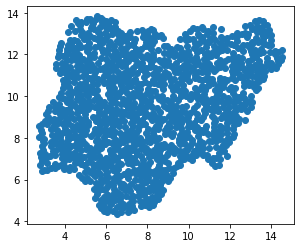

In [113]:
train_val_set.plot()

### Make last split

In [114]:
val_set = sample_n_points(train_val_set, n_val, buffer)
val_set['set'] = 'validation'
val_set

too close! 27.422257026273126
too close! 19.0355716144882
too close! 15.311596645551672
too close! 15.813926920820785
too close! 22.828187748115802
too close! 19.038013256807172
too close! 29.79834595436569
too close! 25.972045940084744
too close! 20.851344296877407
too close! 16.71245781578667
too close! 16.5940595521639
too close! 24.43851494377537
too close! 22.915262863724145
too close! 21.51140328247864
too close! 15.420718161267226
too close! 18.747064326681887
too close! 20.619641147909164
too close! 29.691921220753965
too close! 20.727395612252682
too close! 22.163235895723773
too close! 25.49523970288357
too close! 15.597036954276435
too close! 25.49523970288357
too close! 29.79834595436569
too close! 26.77878245182329
too close! 16.36118363323969
too close! 24.902135120025516
too close! 19.891224057033345
too close! 21.727222539565552
too close! 22.667731899737138
too close! 24.226398905484842
too close! 20.58375467685172
too close! 20.537657013850367
too close! 25.1280772549

,identifier,date,lat,lon,label,filename,set,geometry
342,1438,2019-04-03_2020-03-28,7.966934,2.976433,0,1438_2019-04-03_2020-03-28.pkl,validation,POINT (2.97643 7.96693)
1507,1171,2019-04-03_2020-03-28,7.207498,7.468459,0,1171_2019-04-03_2020-03-28.pkl,validation,POINT (7.46846 7.20750)
1802,1727,2019-04-03_2020-03-28,11.074745,8.984186,1,1727_2019-04-03_2020-03-28.pkl,validation,POINT (8.98419 11.07475)
336,585,2019-04-03_2020-03-28,7.143358,9.897862,1,585_2019-04-03_2020-03-28.pkl,validation,POINT (9.89786 7.14336)
1543,731,2019-04-03_2020-03-28,8.460827,11.653440,0,731_2019-04-03_2020-03-28.pkl,validation,POINT (11.65344 8.46083)
...,...,...,...,...,...,...,...,...
1628,1573,2019-04-03_2020-03-28,8.078594,6.313135,0,1573_2019-04-03_2020-03-28.pkl,validation,POINT (6.31314 8.07859)
1717,1753,2019-04-03_2020-03-28,11.706081,8.980682,1,1753_2019-04-03_2020-03-28.pkl,validation,POINT (8.98068 11.70608)
80,3,2019-04-03_2020-03-28,6.506273,6.584157,0,3_2019-04-03_2020-03-28.pkl,validation,POINT (6.58416 6.50627)
147,1555,2019-04-03_2020-03-28,9.333002,7.731126,1,1555_2019-04-03_2020-03-28.pkl,validation,POINT (7.73113 9.33300)


In [115]:
train_set = gdf.iloc[train_val_set.index.difference(val_set.index)]
train_set['set'] = 'training'
train_set

/home/gajo/miniconda3/envs/togo-paper/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,identifier,date,lat,lon,label,filename,set,geometry
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379)
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528)
4,345,2019-04-03_2020-03-28,10.169154,3.810788,0,345_2019-04-03_2020-03-28.pkl,training,POINT (3.81079 10.16915)
5,637,2019-04-03_2020-03-28,11.347294,13.610150,0,637_2019-04-03_2020-03-28.pkl,training,POINT (13.61015 11.34729)
6,1803,2019-04-03_2020-03-28,12.330321,11.564147,1,1803_2019-04-03_2020-03-28.pkl,training,POINT (11.56415 12.33032)
...,...,...,...,...,...,...,...,...
1822,1821,2019-04-03_2020-03-28,12.432728,12.860416,1,1821_2019-04-03_2020-03-28.pkl,training,POINT (12.86042 12.43273)
1823,1495,2019-04-03_2020-03-28,8.249813,6.666982,1,1495_2019-04-03_2020-03-28.pkl,training,POINT (6.66698 8.24981)
1824,1390,2019-04-03_2020-03-28,4.725363,7.672107,0,1390_2019-04-03_2020-03-28.pkl,training,POINT (7.67211 4.72536)
1825,1361,2019-04-03_2020-03-28,6.654585,9.413760,0,1361_2019-04-03_2020-03-28.pkl,training,POINT (9.41376 6.65458)


In [117]:
train_val_set[~train_val_set.index.isin(val_set.index)]

,identifier,date,lat,lon,label,filename,set,geometry
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379)
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528)
4,345,2019-04-03_2020-03-28,10.169154,3.810788,0,345_2019-04-03_2020-03-28.pkl,training,POINT (3.81079 10.16915)
5,637,2019-04-03_2020-03-28,11.347294,13.610150,0,637_2019-04-03_2020-03-28.pkl,training,POINT (13.61015 11.34729)
6,1803,2019-04-03_2020-03-28,12.330321,11.564147,1,1803_2019-04-03_2020-03-28.pkl,training,POINT (11.56415 12.33032)
...,...,...,...,...,...,...,...,...
1822,1821,2019-04-03_2020-03-28,12.432728,12.860416,1,1821_2019-04-03_2020-03-28.pkl,testing,POINT (12.86042 12.43273)
1823,1495,2019-04-03_2020-03-28,8.249813,6.666982,1,1495_2019-04-03_2020-03-28.pkl,testing,POINT (6.66698 8.24981)
1824,1390,2019-04-03_2020-03-28,4.725363,7.672107,0,1390_2019-04-03_2020-03-28.pkl,testing,POINT (7.67211 4.72536)
1825,1361,2019-04-03_2020-03-28,6.654585,9.413760,0,1361_2019-04-03_2020-03-28.pkl,testing,POINT (9.41376 6.65458)


In [56]:
val_set['label'].sum()/len(val_set)

0.4100877192982456

In [57]:
train_set['label'].sum()/len(train_set)

0.4131147540983607

<AxesSubplot:>

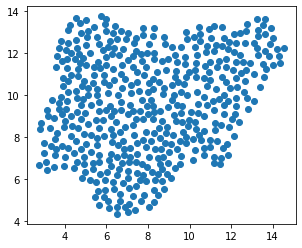

In [60]:
val_set.plot()

<AxesSubplot:>

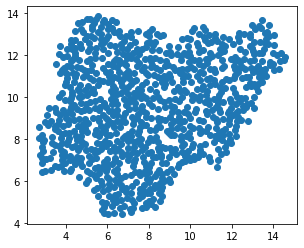

In [61]:
train_set.plot()

In [62]:
new_gdf = pd.concat([train_set, val_set, test_set])
new_gdf

,identifier,date,lat,lon,label,filename,set,geometry
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379)
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528)
3,372,2019-04-03_2020-03-28,5.029802,6.423448,0,372_2019-04-03_2020-03-28.pkl,training,POINT (6.42345 5.02980)
4,345,2019-04-03_2020-03-28,10.169154,3.810788,0,345_2019-04-03_2020-03-28.pkl,training,POINT (3.81079 10.16915)
5,637,2019-04-03_2020-03-28,11.347294,13.610150,0,637_2019-04-03_2020-03-28.pkl,training,POINT (13.61015 11.34729)
...,...,...,...,...,...,...,...,...
1068,1051,2019-04-03_2020-03-28,6.626288,8.736071,0,1051_2019-04-03_2020-03-28.pkl,testing,POINT (8.73607 6.62629)
1430,1034,2019-04-03_2020-03-28,12.948451,4.159335,0,1034_2019-04-03_2020-03-28.pkl,testing,POINT (4.15933 12.94845)
449,327,2019-04-03_2020-03-28,10.662688,10.429845,0,327_2019-04-03_2020-03-28.pkl,testing,POINT (10.42984 10.66269)
1567,1655,2019-04-03_2020-03-28,7.165547,10.563783,0,1655_2019-04-03_2020-03-28.pkl,testing,POINT (10.56378 7.16555)


In [67]:
# Check that new assigments are reflected in the set column
(train_set['set'] == 'training').sum() + (val_set['set'] == 'validation').sum() + (test_set['set'] == 'testing').sum() == len(gdf)

True

### Visualize improvement in spatial distribution

<AxesSubplot:>

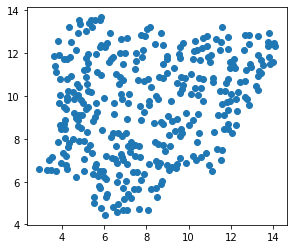

In [58]:
# Before
new_gdf[new_gdf['set'] == 'testing'].plot()

<AxesSubplot:>

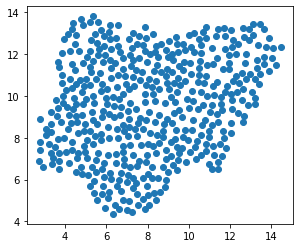

In [70]:
# After
new_gdf[new_gdf['new_set'] == 'testing'].plot()

<AxesSubplot:>

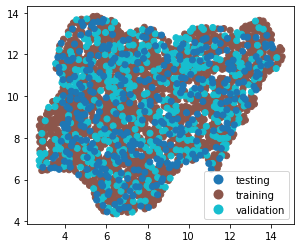

In [71]:
# Before
new_gdf.plot(column='set', legend=True)

<AxesSubplot:>

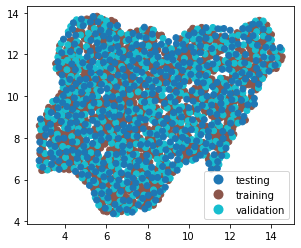

In [72]:
# After
new_gdf.plot(column='new_set', legend=True)

In [84]:
n_train + n_val + n_test

1827

### Reasign folder

In [133]:
new_gdf

,identifier,date,lat,lon,label,filename,set,geometry,new_set
0,898,2019-04-03_2020-03-28,6.993789,7.027655,0,898_2019-04-03_2020-03-28.pkl,training,POINT (7.02766 6.99379),training
2,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,POINT (4.59376 8.60528),training
3,372,2019-04-03_2020-03-28,5.029802,6.423448,0,372_2019-04-03_2020-03-28.pkl,training,POINT (6.42345 5.02980),training
5,637,2019-04-03_2020-03-28,11.347294,13.610150,0,637_2019-04-03_2020-03-28.pkl,training,POINT (13.61015 11.34729),training
9,732,2019-04-03_2020-03-28,11.452846,4.053154,1,732_2019-04-03_2020-03-28.pkl,training,POINT (4.05315 11.45285),training
...,...,...,...,...,...,...,...,...,...
183,541,2019-04-03_2020-03-28,10.507998,9.551382,1,541_2019-04-03_2020-03-28.pkl,training,POINT (9.55138 10.50800),testing
951,599,2019-04-03_2020-03-28,8.998559,5.766151,0,599_2019-04-03_2020-03-28.pkl,training,POINT (5.76615 8.99856),testing
1179,870,2019-04-03_2020-03-28,11.705363,7.289424,1,870_2019-04-03_2020-03-28.pkl,validation,POINT (7.28942 11.70536),testing
1768,1234,2019-04-03_2020-03-28,7.891385,5.039414,0,1234_2019-04-03_2020-03-28.pkl,testing,POINT (5.03941 7.89139),testing


In [30]:
parent_path = Path('../data_split_test/nigeria')

In [66]:
keep_original = True
keep_original = False if (parent_path / 'original_split').exists() else keep_original # only do it the first time
if keep_original:
    # Copy original directory into a new subfolder 
    shutil.copytree(parent_path, parent_path / 'original_split')

for index, row in new_gdf.iterrows():
    source_path = parent_path / row['set'] / row['filename']
    dest_path = parent_path / row['new_set'] / row['filename']
    if source_path == dest_path:
        continue
    shutil.move(source_path, dest_path)

FileNotFoundError: [Errno 2] No such file or directory: '../data_split_test/nigeria/validation/1416_2019-04-03_2020-03-28.pkl'